# Compare performance and hyperparameter influence with traditional CAD design

In [1]:
import sys
import os
sys.path.insert(0,'Z:/Cristina/Section3/NME_DEC')
sys.path.insert(0,'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels')
# pylint: skip-file
import sys
import os
import mxnet as mx
import numpy as np
import pandas as pd
import data
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import model
from autoencoder import AutoEncoderModel
from solver import Solver, Monitor
import logging
import sklearn
from sklearn.manifold import TSNE
from utilities import *
try:
   import cPickle as pickle
except:
   import pickle
import gzip

# for visualization
from sklearn.manifold import TSNE
from utilities import *
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_style("whitegrid")
sns.set_color_codes("pastel")

In [2]:
NME_nxgraphs = r'Z:\Cristina\Section3\breast_MR_NME_biological\NMEs_SER_nxgmetrics'
    
allNMEs_dynamic = pd.read_csv(os.path.join(NME_nxgraphs,'dyn_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_morphology = pd.read_csv(os.path.join(NME_nxgraphs,'morpho_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_texture = pd.read_csv(os.path.join(NME_nxgraphs,'text_roi_records_allNMEs_descStats.csv'), index_col=0)

allNMEs_stage1 = pd.read_csv(os.path.join(NME_nxgraphs,'stage1_roi_records_allNMEs_descStats.csv'), index_col=0)

# to load SERw matrices for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGdatafeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    nxGdatafeatures = pickle.load(fin)

# to load discrall_dict dict for all lesions
with gzip.open(os.path.join(NME_nxgraphs,'nxGnormfeatures_allNMEs_descStats.pklz'), 'rb') as fin:
    discrall_dict_allNMEs = pickle.load(fin)           

#########
# shape input (798L, 427L)     
nxGdiscfeatures = discrall_dict_allNMEs   
print('Loading {} leasions with nxGdiscfeatures of size = {}'.format(nxGdiscfeatures.shape[0], nxGdiscfeatures.shape[1]) )

print('Normalizing dynamic {} leasions with features of size = {}'.format(allNMEs_dynamic.shape[0], allNMEs_dynamic.shape[1]))
normdynamic = (allNMEs_dynamic - allNMEs_dynamic.mean(axis=0)) / allNMEs_dynamic.std(axis=0)
normdynamic.mean(axis=0)

print('Normalizing morphology {} leasions with features of size = {}'.format(allNMEs_morphology.shape[0], allNMEs_morphology.shape[1]))
normorpho = (allNMEs_morphology - allNMEs_morphology.mean(axis=0)) / allNMEs_morphology.std(axis=0)
normorpho.mean(axis=0)

print('Normalizing texture {} leasions with features of size = {}'.format(allNMEs_texture.shape[0], allNMEs_texture.shape[1]))
normtext = (allNMEs_texture - allNMEs_texture.mean(axis=0)) / allNMEs_texture.std(axis=0)
normtext.mean(axis=0)

print('Normalizing stage1 {} leasions with features of size = {}'.format(allNMEs_stage1.shape[0], allNMEs_stage1.shape[1]))
normstage1 = (allNMEs_stage1 - allNMEs_stage1.mean(axis=0)) / allNMEs_stage1.std(axis=0)
normstage1.mean(axis=0)

# shape input (798L, 427L)    
combX_allNME = np.concatenate((nxGdiscfeatures, normdynamic.as_matrix(), normorpho.as_matrix(), normtext.as_matrix(), normstage1.as_matrix()), axis=1)       
YnxG_allNME = np.asarray([nxGdatafeatures['roi_id'].values,
        nxGdatafeatures['classNME'].values,
        nxGdatafeatures['nme_dist'].values,
        nxGdatafeatures['nme_int'].values])

print('Loading {} all NME of size = {}'.format(combX_allNME.shape[0], combX_allNME.shape[1]) )
print('Loading all NME lables [label,BIRADS,dist,enh] of size = {}'.format(YnxG_allNME[0].shape[0])   )



Loading 792 leasions with nxGdiscfeatures of size = 326
Normalizing dynamic 792 leasions with features of size = 34
Normalizing morphology 792 leasions with features of size = 19
Normalizing texture 792 leasions with features of size = 44
Normalizing stage1 792 leasions with features of size = 100
Loading 792 all NME of size = 523
Loading all NME lables [label,BIRADS,dist,enh] of size = 792


# Collect decModel_wimgF_dualopt_descStats

Loading autoencoder of znum = 261, mu = 3 , post training DEC results
DEC train init AUC = 0.673262032086
DEC train max meanAuc_cv = 0.732642602496 $\pm$ 0.0931672775493
DEC validation AUC at max meanAuc_cv = 0.775172413793

... MLP fully coneected layer trained on Z_train tested on Z_test
Loading autoencoder of znum = 261, mu = 4 , post training DEC results
DEC train init AUC = 0.677963458111
DEC train max meanAuc_cv = 0.731417112299 $\pm$ 0.0895483390756
DEC validation AUC at max meanAuc_cv = 0.740689655172

... MLP fully coneected layer trained on Z_train tested on Z_test
Loading autoencoder of znum = 261, mu = 5 , post training DEC results
DEC train init AUC = 0.685658051099
DEC train max meanAuc_cv = 0.734061200238 $\pm$ 0.0829846283581
DEC validation AUC at max meanAuc_cv = 0.702068965517

... MLP fully coneected layer trained on Z_train tested on Z_test
Loading autoencoder of znum = 261, mu = 6 , post training DEC results
DEC train init AUC = 0.687923351159
DEC train max meanAuc

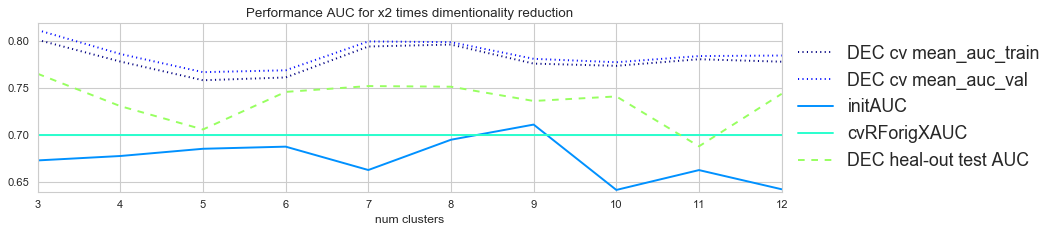

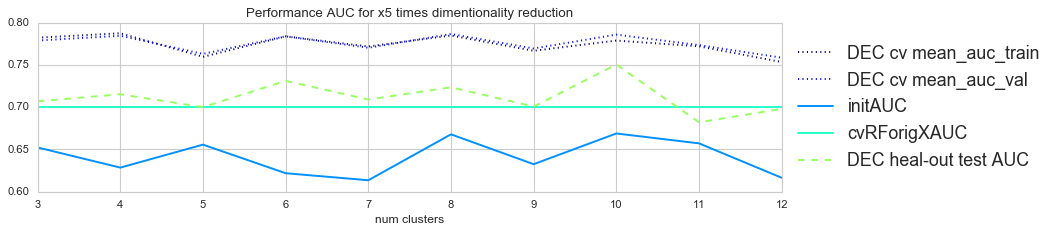

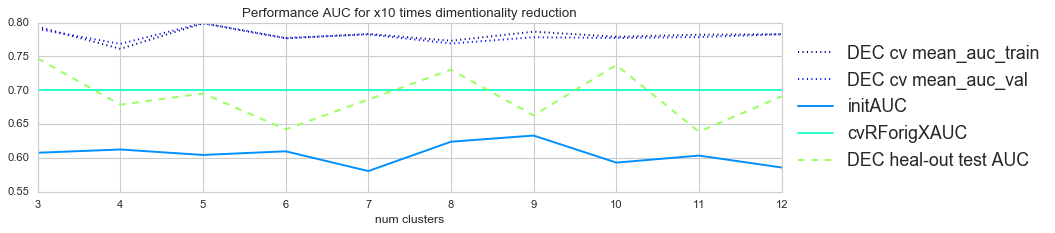

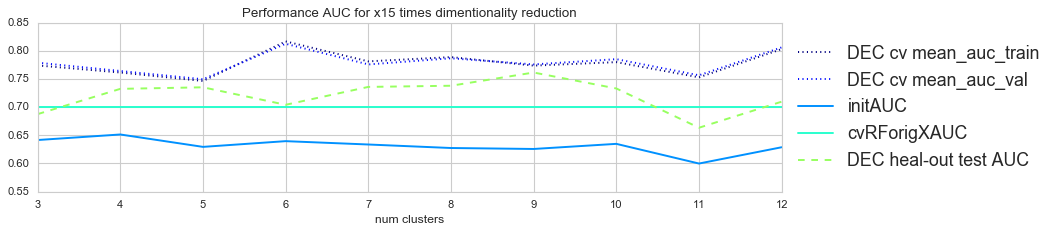

In [3]:
from decModel_wimgF_dualopt_descStats import *
labeltype = 'wimgF_dualopt_descStats_saveparams' 
save_to = r'Z:\Cristina\Section3\NME_DEC\SAEmodels\decModel_wimgF_dualopt_descStats_saveparams'

# to load a prevously DEC model  
input_size = combX_allNME.shape[1]
latent_size = [input_size/rxf for rxf in [2,5,10,15]]
varying_mu = [int(np.round(var_mu)) for var_mu in np.linspace(3,12,10)]
sns.set_color_codes("pastel")

# define variables for DEC 
roi_labels = YnxG_allNME[1]  
roi_labels = ['K' if rl=='U' else rl for rl in roi_labels]

# to hold the hyperparams
grd = np.array([(zs, mus) for zs in latent_size for mus in varying_mu])
grdperf_DEC = pd.DataFrame(grd)
grdperf_DEC.columns = ["Zsize","n_mu"]

######################
# DEC: define num_centers according to clustering variable
######################   
# to load a prevously DEC model  
cvRForigXAUC = []; 
initAUC = []; 
cvRFZspaceAUC_cvtrain = []; 
cvRFZspace_stdAUC_cvtrain = [];
cvRFZspaceAUC_cvVal = []; 
cvRFZspace_stdAUC_cvVal = [];
TestAUC = []; 

for ik,znum in enumerate(latent_size):
    to_plotcvRForigXAUC=[]
    to_plotinitAUC=[]
    to_plotcvRFZspaceAUC_cvtrain=[]
    to_plotcvRFZspace_stdAUC_cvtrain=[]
    to_plotcvRFZspaceAUC_cvVal=[]
    to_plotcvRFZspace_stdAUC_cvVal=[]
    to_plotTestAUC=[]
    for ic,num_centers in enumerate(varying_mu):  
        X = combX_allNME
        y = roi_labels
        y_train_roi_labels = np.asarray(y)

        print('Loading autoencoder of znum = {}, mu = {} , post training DEC results'.format(znum,num_centers))
        dec_model = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

        with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            dec_model = pickle.load(fu)
          
        with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(znum,num_centers,labeltype)), 'rb') as fu:
            outdict = pickle.load(fu)
        
        print('DEC train init AUC = {}'.format(outdict['meanAuc_cv'][0]))
        max_meanAuc_cv = outdict['meanAuc_cv'][-1]
        indmax_meanAuc_cv = outdict['meanAuc_cv'].index(max_meanAuc_cv)
        print r'DEC train max meanAuc_cv = {} $\pm$ {}'.format(max_meanAuc_cv,dec_model['std_auc'][indmax_meanAuc_cv])
        print('DEC validation AUC at max meanAuc_cv = {}'.format(outdict['auc_val'][indmax_meanAuc_cv]))
        
        #####################
        # extract Z-space from optimal DEC model
        #####################
        # saved output results
        dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
        'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
        'encoder_3_bias', 'encoder_2_bias']
        dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
        dec_args['dec_mubestacci'] = dec_model['dec_mu']
        
        N = X.shape[0]
        all_iter = mx.io.NDArrayIter({'data': X}, batch_size=X.shape[0], shuffle=False,
                                                  last_batch_handle='pad')   
        ## extract embedded point zi 
        mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
        aDEC = DECModel(mx.cpu(), X, num_centers, 1.0, znum, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 
        
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in aDEC.ae_model.args.iteritems()]
        k1=[k for k,v in aDEC.ae_model.args.iteritems()]
        l2=[v.asnumpy().shape for k,v in mxdec_args.iteritems()]
        k2=[k for k,v in mxdec_args.iteritems()]

        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    aDEC.ae_model.args[k1[ikparam]] = mxdec_args[k2[jkparam]]

        zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      

        # compute model-based best-pbestacci or dec_model['pbestacci']
        pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
        aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
        #pbestacci = dec_model['pbestacci']
        
        # pool Z-space variables
        datalabels = np.asarray(y)
        dataZspace = np.concatenate((zbestacci, pbestacci), axis=1) 

        #####################
        # unbiased assessment: SPlit train/held-out test
        #####################
        # to compare performance need to discard unkown labels, only use known labels (only B or M)
        Z = dataZspace[datalabels!='K',:]
        y = datalabels[datalabels!='K']
      
        print '\n... MLP fully coneected layer trained on Z_train tested on Z_test' 
        sep = int(X.shape[0]*0.10)
        Z_test = Z[:sep]
        yZ_test = np.asanyarray(y[:sep]=='M').astype(int) 
        Z_train = Z[sep:]
        yZ_train = np.asanyarray(y[sep:]=='M').astype(int) 
       
        # We’ll load MLP using MXNet’s symbolic interface
        dataMLP = mx.sym.Variable('data')
        # MLP: two fully connected layers with 128 and 32 neurons each. 
        fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
        act1 = mx.sym.Activation(data=fc1, act_type="relu")
        fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
        act2 = mx.sym.Activation(data=fc2, act_type="relu")
        # data has 2 classes
        fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
        # Softmax output layer
        mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
        # create a trainable module on CPU     
        batch_size = 50
        mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
        # pass train/test data to allocate model (bind state)
        MLP_train_iter = mx.io.NDArrayIter(Z_train, yZ_train, batch_size, shuffle=False)
        mlp_model.bind(MLP_train_iter.provide_data, MLP_train_iter.provide_label)
        mlp_model.init_params()   
        mlp_model.init_optimizer()
        mlp_model_params = mlp_model.get_params()[0]
        
        # update parameters based on optimal found during cv Training
        from mxnet import ndarray
        params_dict = ndarray.load(os.path.join(save_to,'mlp_model_params_z{}_mu{}.arg'.format(znum,num_centers)))
        arg_params = {}
        aux_params = {}
        for k, value in params_dict.items():
            arg_type, name = k.split(':', 1)
            if arg_type == 'arg':
                arg_params[name] = value
            elif arg_type == 'aux':
                aux_params[name] = value
            else:
                raise ValueError("Invalid param file ")

        # order of params: [(128L, 266L),(128L,),(32L, 128L),(32L,),(2L, 32L),(2L,)]
        # organize weights and biases
        l1=[v.asnumpy().shape for k,v in mlp_model_params.iteritems()]
        k1=[k for k,v in mlp_model_params.iteritems()]
        l2=[v.asnumpy().shape for k,v in arg_params.iteritems()]
        k2=[k for k,v in arg_params.iteritems()]

        for ikparam,sizeparam in enumerate(l1):
            for jkparam,savedparam in enumerate(l2):
                if(sizeparam == savedparam):
                    #print('updating layer parameters: {}'.format(savedparam))
                    mlp_model_params[k1[ikparam]] = arg_params[k2[jkparam]]
        # upddate model parameters
        mlp_model.set_params(mlp_model_params, aux_params)
        
        #####################
        # ROC: Z-space MLP fully coneected layer for classification
        #####################
        # Run classifier with cross-validation and plot ROC curves
        cv = StratifiedKFold(n_splits=5,random_state=3)
        # Evaluate a score by cross-validation
        tprs_train = []; aucs_train = []
        tprs_val = []; aucs_val = []
        mean_fpr = np.linspace(0, 1, 100)
        cvi = 0
        for train, test in cv.split(Z_train, yZ_train):
            ############### on train
            MLP_train_iter = mx.io.NDArrayIter(Z_train[train], yZ_train[train], batch_size)  
            # prob[i][j] is the probability that the i-th validation contains the j-th output class.
            prob_train = mlp_model.predict(MLP_train_iter)
            # Compute ROC curve and area the curve
            fpr_train, tpr_train, thresholds_train = roc_curve(yZ_train[train], prob_train.asnumpy()[:,1])
            # to create an ROC with 100 pts
            tprs_train.append(interp(mean_fpr, fpr_train, tpr_train))
            tprs_train[-1][0] = 0.0
            roc_auc = auc(fpr_train, tpr_train)
            aucs_train.append(roc_auc)
            
            ############### on validation
            MLP_val_iter = mx.io.NDArrayIter(Z_train[test], yZ_train[test], batch_size)    
            # prob[i][j] is the probability that the i-th validation contains the j-th output class.
            prob_val = mlp_model.predict(MLP_val_iter)
            # Compute ROC curve and area the curve
            fpr_val, tpr_val, thresholds_val = roc_curve(yZ_train[test], prob_val.asnumpy()[:,1])
            # to create an ROC with 100 pts
            tprs_val.append(interp(mean_fpr, fpr_val, tpr_val))
            tprs_val[-1][0] = 0.0
            roc_auc = auc(fpr_val, tpr_val)
            aucs_val.append(roc_auc)
            cvi += 1
           
        # mean and +- 1 -std as fill area
        mean_tpr_train = np.mean(tprs_train, axis=0)
        mean_tpr_train[-1] = 1.0
        mean_auc_train = auc(mean_fpr, mean_tpr_train)
        std_auc_train = np.std(aucs_train)
        
        # for cv val
        mean_tpr_val = np.mean(tprs_val, axis=0)
        mean_tpr_val[-1] = 1.0
        mean_auc_val = auc(mean_fpr, mean_tpr_val)
        std_auc_val = np.std(aucs_val)
         
        ################
        # plot AUC on heldout set
        ################
        MLP_heldout_iter = mx.io.NDArrayIter(Z_test, None, batch_size)   
        probas_heldout = mlp_model.predict(MLP_heldout_iter)
           
        # for Z_test
        fpr_test, tpr_test, thresholds_test = roc_curve(yZ_test, probas_heldout.asnumpy()[:, 1])
        auc_test = auc(fpr_test, tpr_test)
        
        ############# append to 
        cvRForigXAUC.append(0.70)
        initAUC.append(dec_model['meanAuc_cv'][0])
        cvRFZspaceAUC_cvtrain.append(mean_auc_train)
        cvRFZspace_stdAUC_cvtrain.append(std_auc_train)
        cvRFZspaceAUC_cvVal.append(mean_auc_val)
        cvRFZspace_stdAUC_cvVal.append(std_auc_val)
        TestAUC.append(auc_test)
        # just ot plot
        to_plotcvRForigXAUC.append(0.70)
        to_plotinitAUC.append(dec_model['meanAuc_cv'][0])
        to_plotcvRFZspaceAUC_cvtrain.append(mean_auc_train)
        to_plotcvRFZspaceAUC_cvVal.append(mean_auc_val)
        to_plotTestAUC.append(auc_test)
        
    # plot latent space Accuracies vs. original
    colors = plt.cm.jet(np.linspace(0, 1, 16))
    fig2 = plt.figure(figsize=(12,6))
    #ax2 = plt.axes()
    sns.set_context("notebook")
    ax1 = fig2.add_subplot(2,1,1)
    ax1.plot(varying_mu, to_plotcvRFZspaceAUC_cvtrain, color=colors[0], ls=':', label="DEC cv mean_auc_train")
    ax1.plot(varying_mu, to_plotcvRFZspaceAUC_cvVal, color=colors[2], ls=':', label="DEC cv mean_auc_val")
    ax1.plot(varying_mu, to_plotinitAUC, color=colors[4], label='initAUC')
    ax1.plot(varying_mu, to_plotcvRForigXAUC, color=colors[6], label='cvRForigXAUC')
    ax1.plot(varying_mu, to_plotTestAUC, color=colors[8], ls='--', label="DEC heal-out test AUC")
    ax1.set_title("Performance AUC for x{} times dimentionality reduction".format(input_size/znum))
    ax1.set_xlabel("num clusters")
    h1, l1 = ax1.get_legend_handles_labels()
    ax1.legend(h1, l1, loc='center left', bbox_to_anchor=(1, 0.5), prop={'size':16})
    
    print("summary stats at x{} times dimentionality reduction".format(input_size/znum))
    print("mean cvRFZspaceAUC_cvtrain ={}".format(np.mean(to_plotcvRFZspaceAUC_cvtrain)))
    print("std cvRFZspaceAUC_cvtrain ={}".format(np.std(to_plotcvRFZspaceAUC_cvtrain)))
    print("mean cvRFZspaceAUC_cvVal ={}".format(np.mean(to_plotcvRFZspaceAUC_cvVal)))
    print("std cvRFZspaceAUC_cvVal ={}".format(np.std(to_plotcvRFZspaceAUC_cvVal)))
    print("mean TestAUC ={}".format(np.mean(to_plotTestAUC)))
    print("std TesAUC ={}".format(np.std(to_plotTestAUC)))
     
     

In [4]:
# finish fromating DEC performance
grdperf_DEC['cvRForigXAUC'] = cvRForigXAUC
grdperf_DEC['initAUC'] = initAUC
grdperf_DEC['cvRFZspaceAUC_cvtrain'] = cvRFZspaceAUC_cvtrain
grdperf_DEC['cvRFZspace_stdAUC_cvtrain'] = cvRFZspace_stdAUC_cvtrain
grdperf_DEC['cvRFZspaceAUC_cvVal'] = cvRFZspaceAUC_cvVal
grdperf_DEC['cvRFZspace_stdAUC_cvVal'] = cvRFZspace_stdAUC_cvVal
grdperf_DEC['TestAUC'] = TestAUC
print(grdperf_DEC)

    Zsize  n_mu  cvRForigXAUC   initAUC  cvRFZspaceAUC_cvtrain  \
0     261     3           0.7  0.673262               0.801616   
1     261     4           0.7  0.677963               0.778517   
2     261     5           0.7  0.685658               0.758591   
3     261     6           0.7  0.687923               0.761565   
4     261     7           0.7  0.663050               0.794541   
5     261     8           0.7  0.695291               0.796605   
6     261     9           0.7  0.711416               0.776311   
7     261    10           0.7  0.641837               0.773957   
8     261    11           0.7  0.662968               0.780966   
9     261    12           0.7  0.642558               0.778359   
10    104     3           0.7  0.652258               0.782138   
11    104     4           0.7  0.628461               0.787349   
12    104     5           0.7  0.655622               0.759464   
13    104     6           0.7  0.621821               0.783653   
14    104 

In [5]:
# find best performing by the average of broth train and test performance
max_aucZlatent = np.max(grdperf_DEC[["cvRFZspaceAUC_cvtrain", "cvRFZspaceAUC_cvVal","TestAUC"]].mean(axis=1))
indmax_meanAuc_cv = grdperf_DEC[["cvRFZspaceAUC_cvtrain", "cvRFZspaceAUC_cvVal","TestAUC"]].mean(axis=1) == max_aucZlatent
print "\n================== Best average train/test perfomance parameters:" 
bestperf_params = grdperf_DEC[indmax_meanAuc_cv]
print bestperf_params


================== Best average train/test perfomance parameters:
   Zsize  n_mu  cvRForigXAUC   initAUC  cvRFZspaceAUC_cvtrain  \
0    261     3           0.7  0.673262               0.801616   

   cvRFZspace_stdAUC_cvtrain  cvRFZspaceAUC_cvVal  cvRFZspace_stdAUC_cvVal  \
0                   0.025357             0.811988                 0.104961   

    TestAUC  
0  0.765517  


In [6]:
################################################################## 
Zspacedim_best = int(bestperf_params.iloc[0]['Zsize'])
num_clusters_best = int(bestperf_params.iloc[0]['n_mu'])

print('Loading autoencoder of Zspacedim_best = {}, mu = {} , post training DEC results'.format(Zspacedim_best,num_clusters_best))
dec_model = DECModel(mx.cpu(), X, num_clusters_best, 1.0, Zspacedim_best, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

with gzip.open(os.path.join(save_to,'dec_model_z{}_mu{}_{}.arg'.format(Zspacedim_best,num_clusters_best,labeltype)), 'rb') as fu:
    dec_model = pickle.load(fu)
  
with gzip.open(os.path.join(save_to,'outdict_z{}_mu{}_{}.arg'.format(Zspacedim_best,num_clusters_best,labeltype)), 'rb') as fu:
    outdict = pickle.load(fu)

#####################
# extract Z-space from optimal DEC model
#####################
# saved output results
X = combX_allNME
y = roi_labels

dec_args_keys = ['encoder_1_bias', 'encoder_3_weight', 'encoder_0_weight', 
'encoder_0_bias', 'encoder_2_weight', 'encoder_1_weight', 
'encoder_3_bias', 'encoder_2_bias']
dec_args = {key: v for key, v in dec_model.items() if key in dec_args_keys}
dec_args['dec_mubestacci'] = dec_model['dec_mu']

N = X.shape[0]
all_iter = mx.io.NDArrayIter({'data': X}, batch_size=X.shape[0], shuffle=False,
                                          last_batch_handle='pad')   
## extract embedded point zi 
mxdec_args = {key: mx.nd.array(v) for key, v in dec_args.items() if key != 'dec_mubestacci'}                           
aDEC = DECModel(mx.cpu(), X, num_clusters_best, 1.0, Zspacedim_best, 'Z:\\Cristina\\Section3\\NME_DEC\\SAEmodels') 

# organize weights and biases
l1=[v.asnumpy().shape for k,v in aDEC.ae_model.args.iteritems()]
k1=[k for k,v in aDEC.ae_model.args.iteritems()]
l2=[v.asnumpy().shape for k,v in mxdec_args.iteritems()]
k2=[k for k,v in mxdec_args.iteritems()]

for ikparam,sizeparam in enumerate(l1):
    for jkparam,savedparam in enumerate(l2):
        if(sizeparam == savedparam):
            #print('updating layer parameters: {}'.format(savedparam))
            aDEC.ae_model.args[k1[ikparam]] = mxdec_args[k2[jkparam]]

zbestacci = model.extract_feature(aDEC.feature, mxdec_args, None, all_iter, X.shape[0], aDEC.xpu).values()[0]      
# compute model-based best-pbestacci or dec_model['pbestacci']
pbestacci = np.zeros((zbestacci.shape[0], dec_model['num_centers']))
aDEC.dec_op.forward([zbestacci, dec_args['dec_mubestacci'].asnumpy()], [pbestacci])
#pbestacci = dec_model['pbestacci']

# pool Z-space variables
datalabels = np.asarray(y)
dataZspace = np.concatenate((zbestacci, pbestacci), axis=1) 

#####################
# unbiased assessment: SPlit train/held-out test
#####################
# to compare performance need to discard unkown labels, only use known labels (only B or M)
Z = dataZspace[datalabels!='K',:]
y = datalabels[datalabels!='K']
  
print '\n... MLP fully coneected layer trained on Z_train tested on Z_test' 
sep = int(X.shape[0]*0.10)
Z_test = Z[:sep]
yZ_test = np.asanyarray(y[:sep]=='M').astype(int) 
Z_train = Z[sep:]
yZ_train = np.asanyarray(y[sep:]=='M').astype(int) 
   
# We’ll load MLP using MXNet’s symbolic interface
dataMLP = mx.sym.Variable('data')
# MLP: two fully connected layers with 128 and 32 neurons each. 
fc1  = mx.sym.FullyConnected(data=dataMLP, num_hidden = 128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 32)
act2 = mx.sym.Activation(data=fc2, act_type="relu")
# data has 2 classes
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=2)
# Softmax output layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')
# create a trainable module on CPU     
batch_size = 50
mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())
# pass train/test data to allocate model (bind state)
MLP_train_iter = mx.io.NDArrayIter(Z_train, yZ_train, batch_size, shuffle=False)
mlp_model.bind(MLP_train_iter.provide_data, MLP_train_iter.provide_label)
mlp_model.init_params()   
mlp_model_params = mlp_model.get_params()[0]

# update parameters based on optimal found during cv Training
from mxnet import ndarray
params_dict = ndarray.load(os.path.join(save_to,'mlp_model_params_z{}_mu{}.arg'.format(Zspacedim_best,num_clusters_best)))
arg_params = {}
aux_params = {}
for k, value in params_dict.items():
    arg_type, name = k.split(':', 1)
    if arg_type == 'arg':
        arg_params[name] = value
    elif arg_type == 'aux':
        aux_params[name] = value
    else:
        raise ValueError("Invalid param file ")

# order of params: [(128L, 266L),(128L,),(32L, 128L),(32L,),(2L, 32L),(2L,)]
# organize weights and biases
l1=[v.asnumpy().shape for k,v in mlp_model_params.iteritems()]
k1=[k for k,v in mlp_model_params.iteritems()]
l2=[v.asnumpy().shape for k,v in arg_params.iteritems()]
k2=[k for k,v in arg_params.iteritems()]

for ikparam,sizeparam in enumerate(l1):
    for jkparam,savedparam in enumerate(l2):
        if(sizeparam == savedparam):
            #print('updating layer parameters: {}'.format(savedparam))
            mlp_model_params[k1[ikparam]] = arg_params[k2[jkparam]]
# upddate model parameters
mlp_model.set_params(mlp_model_params, aux_params)


figROCs = plt.figure(figsize=(12,4))    
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5,random_state=3)
# Evaluate a score by cross-validation
tprs_train = []; aucs_train = []
tprs_val = []; aucs_val = []
mean_fpr = np.linspace(0, 1, 100)
## to append pooled predictions
pooled_pred_train = pd.DataFrame()
pooled_pred_val = pd.DataFrame()
cvi = 0
for train, test in cv.split(Z_train, yZ_train):
    ############### on train
    MLP_train_iter = mx.io.NDArrayIter(Z_train[train], yZ_train[train], batch_size)  
    # prob[i][j] is the probability that the i-th validation contains the j-th output class.
    prob_train = mlp_model.predict(MLP_train_iter)
    # Compute ROC curve and area the curve
    fpr_train, tpr_train, thresholds_train = roc_curve(yZ_train[train], prob_train.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_train.append(interp(mean_fpr, fpr_train, tpr_train))
    tprs_train[-1][0] = 0.0
    roc_auc = auc(fpr_train, tpr_train)
    aucs_train.append(roc_auc)
    
    ############### on validation
    MLP_val_iter = mx.io.NDArrayIter(Z_train[test], yZ_train[test], batch_size)    
    # prob[i][j] is the probability that the i-th validation contains the j-th output class.
    prob_val = mlp_model.predict(MLP_val_iter)
    # Compute ROC curve and area the curve
    fpr_val, tpr_val, thresholds_val = roc_curve(yZ_train[test], prob_val.asnumpy()[:,1])
    # to create an ROC with 100 pts
    tprs_val.append(interp(mean_fpr, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    roc_auc = auc(fpr_val, tpr_val)
    aucs_val.append(roc_auc)
    # plot
    #axaroc.plot(fpr, tpr, lw=1, alpha=0.6) # with label add: label='cv %d, AUC %0.2f' % (cvi, roc_auc)
    cvi += 1
    ## appends
    pooled_pred_train = pooled_pred_train.append( pd.DataFrame({"labels":yZ_train[train],
                          "probC":prob_train.asnumpy()[:,1],
                          "probNC":prob_train.asnumpy()[:,0]}), ignore_index=True)

    pooled_pred_val = pooled_pred_val.append( pd.DataFrame({"labels":yZ_train[test],
                          "probC":prob_val.asnumpy()[:,1],
                          "probNC":prob_val.asnumpy()[:,0]}), ignore_index=True)
                          
# # predict and evaluate performance
# on pool data during cv
pool_fpr_train, pool_tpr_train, pool_thresholds_train = roc_curve(pooled_pred_train['labels'], pooled_pred_train['probC'])
pool_fpr_val, pool_tpr_val, pool_thresholds_val = roc_curve(pooled_pred_val['labels'], pooled_pred_val['probC'])

      

Loading autoencoder of Zspacedim_best = 261, mu = 3 , post training DEC results

... MLP fully coneected layer trained on Z_train tested on Z_test


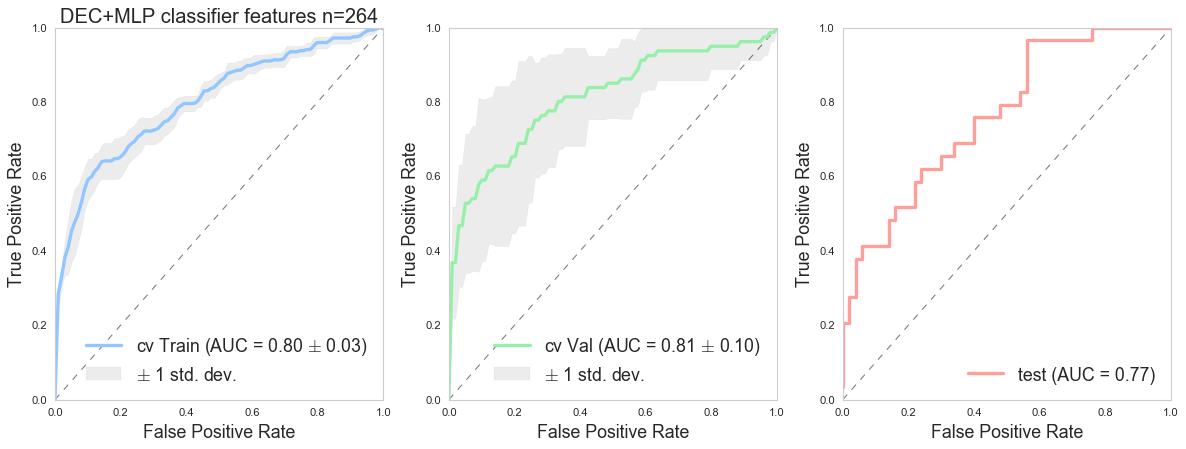

In [7]:
###############################################
## plot ROC curves: 2 ways, Average AUC across cv or from pooled data
###############################################
## Way One: Average AUC across cv
# plot for cv Train       
figROCs = plt.figure(figsize=(18,6))
axaroc_train = figROCs.add_subplot(1,3,1)
# add 50% or chance line
axaroc_train.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_train[-1] = 1.0
mean_auc_train = auc(mean_fpr, mean_tpr_train)
std_auc_train = np.std(aucs_train)
axaroc_train.plot(mean_fpr, mean_tpr_train, color='b',
         label=r'cv Train (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_train, std_auc_train),lw=3, alpha=1) 
# to add std
std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower = np.maximum(mean_tpr_train - std_tpr_train, 0)
axaroc_train.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15, label=r'$\pm$ 1 std. dev.')
# set labels
axaroc_train.set_xlabel('False Positive Rate',fontsize=16)
axaroc_train.set_ylabel('True Positive Rate',fontsize=16)
axaroc_train.set_title('DEC+MLP classifier features n={}'.format(Z_train.shape[1]),fontsize=18)
axaroc_train.legend(loc="lower right",fontsize=16)
axaroc_train.grid("off")

# plot for cv val
axaroc_val = figROCs.add_subplot(1,3,2)
# add 50% or chance line
axaroc_val.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr_val)
std_auc_val = np.std(aucs_val)
axaroc_val.plot(mean_fpr, mean_tpr_val, color='g',
         label=r'cv Val (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),lw=3, alpha=1) 
# to add std
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr_val, 0)
axaroc_val.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15, label=r'$\pm$ 1 std. dev.')
# set labels
axaroc_val.set_xlabel('False Positive Rate',fontsize=16)
axaroc_val.set_ylabel('True Positive Rate',fontsize=16)
axaroc_val.legend(loc="lower right",fontsize=16)
axaroc_val.grid("off")

# plot AUC on heldout set
MLP_heldout_iter = mx.io.NDArrayIter(Z_test, None, batch_size)   
probas_heldout = mlp_model.predict(MLP_heldout_iter)
   
# plot for cv val
axaroc_test = figROCs.add_subplot(1,3,3)
# add 50% or chance line
axaroc_test.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(yZ_test, probas_heldout.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc_test.plot(fpr_test, tpr_test, color='r',
            label=r'test (AUC = %0.2f)' % (auc_test),lw=3, alpha=1)    
# set labels            
axaroc_test.set_xlabel('False Positive Rate',fontsize=16)
axaroc_test.set_ylabel('True Positive Rate',fontsize=16)
axaroc_test.legend(loc="lower right",fontsize=16)
axaroc_test.grid("off")

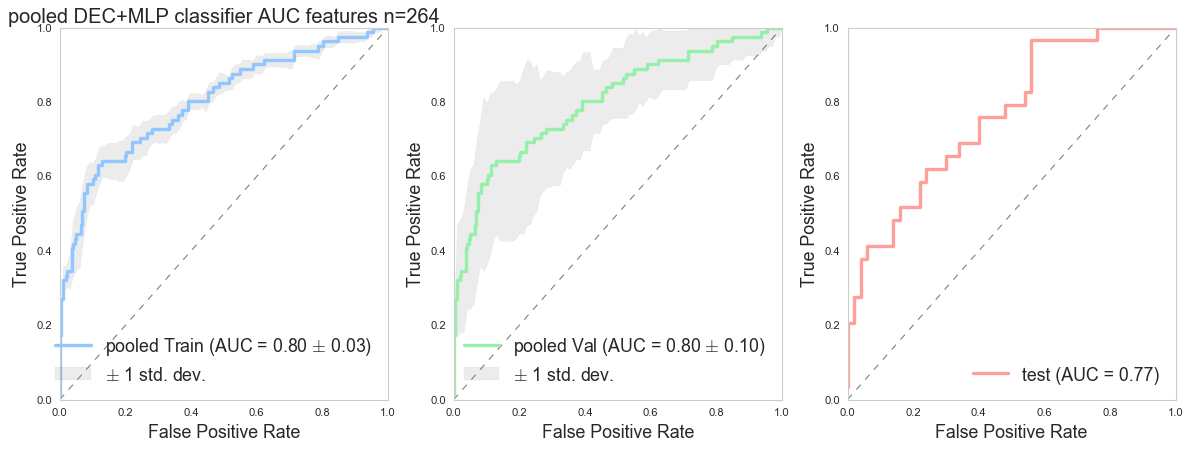

In [8]:
## Way Two: from pooled data
# plot for cv Train       
figROCs = plt.figure(figsize=(18,6))
axaroc_train = figROCs.add_subplot(1,3,1)
# add 50% or chance line
axaroc_train.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot +- 1 -std as fill area
pool_auc_train = auc(pool_fpr_train, pool_tpr_train)
std_auc_train = np.std(aucs_train)
axaroc_train.plot(pool_fpr_train, pool_tpr_train, color='b',
            label=r'pooled Train (AUC = %0.2f $\pm$ %0.2f)' % (pool_auc_train, std_auc_train),lw=3, alpha=1)  
# to add std neet wo interpolate
pool_tpr_train100 = interp(mean_fpr, pool_fpr_train, pool_tpr_train)
std_tpr = np.std(tprs_train, axis=0)
tprs_upper = np.minimum(pool_tpr_train100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_train100 - std_tpr, 0)
axaroc_train.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15,label=r'$\pm$ 1 std. dev.') 
# set labels
axaroc_train.set_xlabel('False Positive Rate',fontsize=16)
axaroc_train.set_ylabel('True Positive Rate',fontsize=16)
axaroc_train.set_title('pooled DEC+MLP classifier AUC features n={}'.format(Z_train.shape[1]),fontsize=18)
axaroc_train.legend(loc="lower right",fontsize=16)
axaroc_train.grid("off")

# plot for cv val
axaroc_val = figROCs.add_subplot(1,3,2)
# add 50% or chance line
axaroc_val.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
pool_auc_val = auc(pool_fpr_val, pool_tpr_val)
std_auc_val = np.std(aucs_val)
axaroc_val.plot(pool_fpr_val, pool_tpr_val, color='g',
            label=r'pooled Val (AUC = %0.2f $\pm$ %0.2f)' % (pool_auc_val, std_auc_val),lw=3, alpha=1)     
# to add std neet wo interpolate
pool_tpr_val100 = interp(mean_fpr, pool_fpr_val, pool_tpr_val)
std_tpr = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(pool_tpr_val100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_val100 - std_tpr, 0)
axaroc_val.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15,label=r'$\pm$ 1 std. dev.') 
# set labels
axaroc_val.set_xlabel('False Positive Rate',fontsize=16)
axaroc_val.set_ylabel('True Positive Rate',fontsize=16)
axaroc_val.legend(loc="lower right",fontsize=16)
axaroc_val.grid("off")

# plot AUC on heldout set
axaroc_test = figROCs.add_subplot(1,3,3)
# add 50% or chance line
axaroc_test.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(yZ_test, probas_heldout.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc_test.plot(fpr_test, tpr_test, color='r',
            label=r'test (AUC = %0.2f)' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc_test.set_xlabel('False Positive Rate',fontsize=16)
axaroc_test.set_ylabel('True Positive Rate',fontsize=16)
axaroc_test.legend(loc="lower right",fontsize=16)
axaroc_test.grid("off")


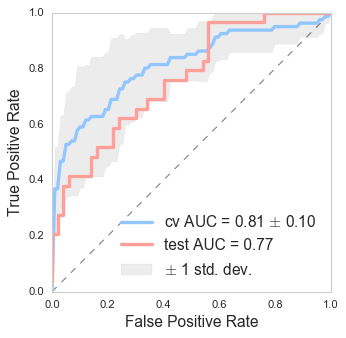

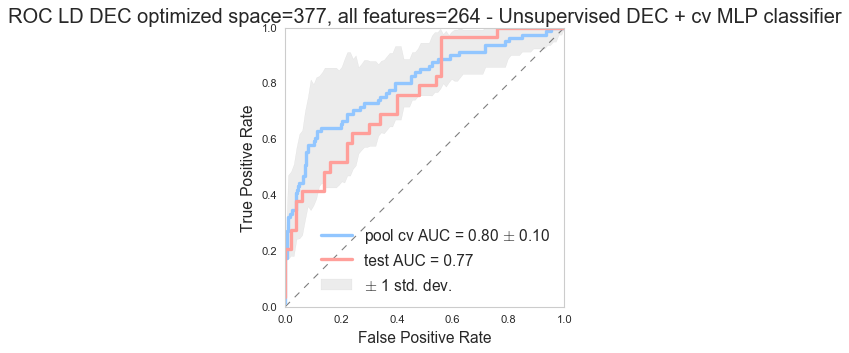

In [9]:
################
# plot for cv val+test in one
################
## Way One: Average AUC across cv
figROCs = plt.figure(figsize=(4.5,4.5))
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr_val)
std_auc_val = np.std(aucs_val)
axaroc.plot(mean_fpr, mean_tpr_val, color='b',
         label=r'cv AUC = %0.2f $\pm$ %0.2f' % (mean_auc_val, std_auc_val),lw=3, alpha=1) 
# to add std
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower = np.maximum(mean_tpr_val - std_tpr_val, 0)
axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15, label=r'$\pm$ 1 std. dev.')
# plot AUC on heldout set
fpr_test, tpr_test, thresholds_test = roc_curve(yZ_test, probas_heldout.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r',
            label=r'test AUC = %0.2f' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=14)
axaroc.set_ylabel('True Positive Rate',fontsize=14)
axaroc.legend(loc="lower right",fontsize=14)
axaroc.grid("off")


## Way Two: from pooled data
figROCs = plt.figure(figsize=(4.5,4.5))
axaroc = figROCs.add_subplot(1,1,1)
# add 50% or chance line
axaroc.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black', alpha=.5)
# plot mean and +- 1 -std as fill area
pool_auc_val = auc(pool_fpr_val, pool_tpr_val)
std_auc_val = np.std(aucs_val)
axaroc.plot(pool_fpr_val, pool_tpr_val, color='b',
            label=r'pool cv AUC = %0.2f $\pm$ %0.2f' % (pool_auc_val, std_auc_val),lw=3, alpha=1)     
# to add std neet wo interpolate
pool_tpr_val100 = interp(mean_fpr, pool_fpr_val, pool_tpr_val)
std_tpr = np.std(tprs_val, axis=0)
tprs_upper = np.minimum(pool_tpr_val100 + std_tpr, 1)
tprs_lower = np.maximum(pool_tpr_val100 - std_tpr, 0)
axaroc.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.15,label=r'$\pm$ 1 std. dev.') 
# Compute ROC curve and area the curve
fpr_test, tpr_test, thresholds_test = roc_curve(yZ_test, probas_heldout.asnumpy()[:, 1])
auc_test = auc(fpr_test, tpr_test)
axaroc.plot(fpr_test, tpr_test, color='r',
            label=r'test AUC = %0.2f' % (auc_test),lw=3, alpha=1)     
# set labels            
axaroc.set_xlabel('False Positive Rate',fontsize=14)
axaroc.set_ylabel('True Positive Rate',fontsize=14)
axaroc.set_title('ROC LD DEC optimized space={}, all features={} - Unsupervised DEC + cv MLP classifier'.format(Z.shape[0],Z.shape[1]),fontsize=18)
axaroc.legend(loc="lower right",fontsize=14)
axaroc.grid("off")


## Load from previous processing comparison_traditionalCAD

In [10]:
traditional_CAD = r'Z:\Cristina\Section3\paper_notes\comparison_traditionalCAD'
grdperf_comb = pd.read_csv(os.path.join(traditional_CAD,'grdperf_comb.csv'), index_col=0)
print(grdperf_comb)

    ntrees  min_samples_split  min_samples_leaf  avaucTrain  stdTrain  \
D                                                                       
3       20                  3                 3    0.912743  0.009730   
3       20                  3                 6    0.896224  0.013119   
3       20                  9                 3    0.901342  0.006510   
3       20                  9                 6    0.896224  0.013119   
3       50                  3                 3    0.931412  0.009188   
3       50                  3                 6    0.927544  0.009004   
3       50                  9                 3    0.930072  0.003561   
3       50                  9                 6    0.927544  0.009004   
3      100                  3                 3    0.944843  0.002729   
3      100                  3                 6    0.932575  0.005452   
3      100                  9                 3    0.940105  0.006208   
3      100                  9                 6    

In [11]:
# separate results for only CAD and with graph features
grdperf_RF = grdperf_comb[grdperf_comb["type"]=='trad_RF']
grdperf_wnxG = grdperf_comb[grdperf_comb["type"]=='tradwnxG_RF']


# plot hyperparameter plots

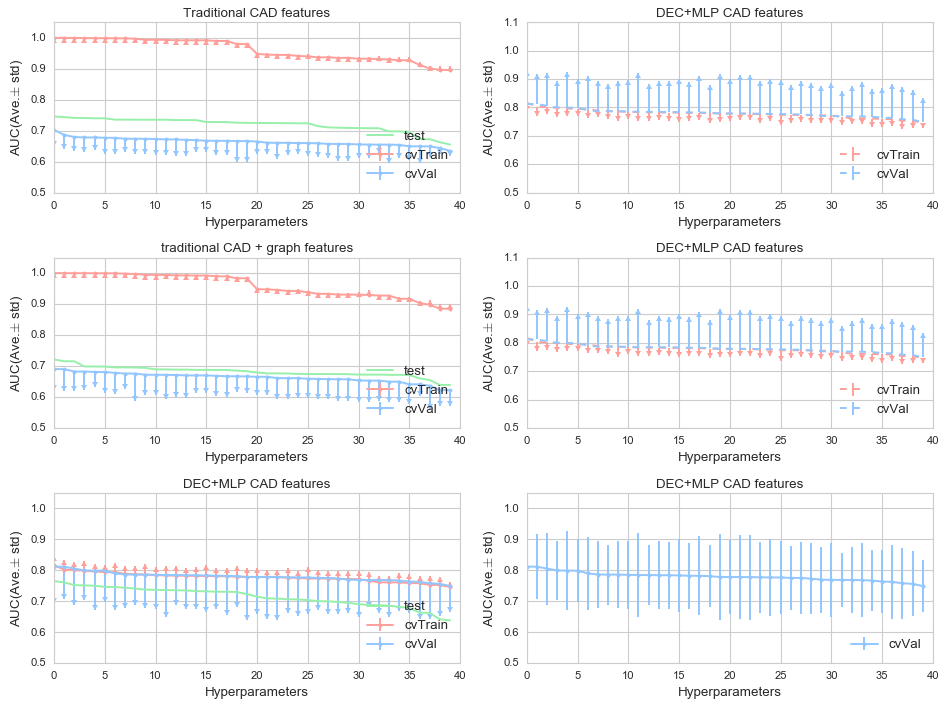

In [13]:
## plot
num_hyp= range(len(grdperf_RF["avaucTrain"]))
figHyperp = plt.figure(figsize=(12,9))
axs1 = figHyperp.add_subplot(3,2,1)
axs2 = figHyperp.add_subplot(3,2,3)
axs3 = figHyperp.add_subplot(3,2,5)

# lower & upper limits of the error
lolims = np.ones(len(num_hyp)).astype(bool)
uplims = np.ones(len(num_hyp)).astype(bool)
ls = 'dotted'

# for cvAUC train
sortauc_Train = grdperf_RF.sort_values(by='avaucTrain',ascending=False)
# for cvAUC val
sortauc_Val = grdperf_RF.sort_values(by='avaucVal',ascending=False)
# sort TestAUC
sortauc_test = grdperf_RF.sort_values(by='auctest',ascending=False)

# plot
axs1.errorbar(x=num_hyp, y=sortauc_Train['avaucTrain'].values,  lolims=lolims,
              yerr=sortauc_Train["stdTrain"].values, fmt='.-r', label='cvTrain')
axs1.errorbar(x=num_hyp, y=sortauc_Val['avaucVal'].values, uplims=uplims,
              yerr=sortauc_Train["stdVal"].values, fmt='.-b', label='cvVal')
axs1.plot(num_hyp, sortauc_test['auctest'].values, 'g', label='test')
axs1.set_title('Traditional CAD features',fontsize=12)
axs1.set_xlabel('Hyperparameters',fontsize=12)
axs1.set_ylabel('AUC(Ave.$\pm$ std)',fontsize=12)
axs1.legend(loc="lower right",fontsize=12)
axs1.set_ylim(0.5,1.05)

# for cvAUC train wiht NXG ffeatures
sortauc_Train = grdperf_wnxG.sort_values(by='avaucTrain',ascending=False)
# for cvAUC val
sortauc_Val = grdperf_wnxG.sort_values(by='avaucVal',ascending=False)
# sort TestAUC
sortauc_test = grdperf_wnxG.sort_values(by='auctest',ascending=False)
# plot
axs2.errorbar(x=num_hyp, y=sortauc_Train['avaucTrain'].values,  lolims=lolims, 
              yerr=sortauc_Train["stdTrain"].values, fmt='.-r', label='cvTrain')
axs2.errorbar(x=num_hyp, y=sortauc_Val['avaucVal'].values, uplims=uplims,
              yerr=sortauc_Train["stdVal"].values, fmt='.-b', barsabove =True, label='cvVal')
axs2.plot(num_hyp, sortauc_test['auctest'].values, 'g', label='test')
axs2.set_title('traditional CAD + graph features',fontsize=12)
axs2.set_xlabel('Hyperparameters',fontsize=12)
axs2.set_ylabel('AUC(Ave.$\pm$ std)',fontsize=12)
axs2.legend(loc="lower right",fontsize=12)
axs2.set_ylim(0.5,1.05)

# for cvAUC train
sortauc_Train = grdperf_DEC.sort_values(by='cvRFZspaceAUC_cvtrain',ascending=False)
# for cvAUC val
sortauc_Val = grdperf_DEC.sort_values(by='cvRFZspaceAUC_cvVal',ascending=False)
# sort TestAUC
sortauc_test = grdperf_DEC.sort_values(by='TestAUC',ascending=False)
# plot
axs3.errorbar(x=num_hyp, y=sortauc_Train['cvRFZspaceAUC_cvtrain'].values, lolims=lolims, 
              yerr=sortauc_Train["cvRFZspace_stdAUC_cvtrain"].values, fmt='.-r', label='cvTrain')
axs3.errorbar(x=num_hyp, y=sortauc_Val['cvRFZspaceAUC_cvVal'].values, uplims=uplims,
              yerr=sortauc_Val["cvRFZspace_stdAUC_cvVal"].values, fmt='.-b', label='cvVal')
axs3.plot(num_hyp, sortauc_test['TestAUC'].values, 'g', label='test')
axs3.set_title('DEC+MLP CAD features',fontsize=12)
axs3.set_xlabel('Hyperparameters',fontsize=12)
axs3.set_ylabel('AUC(Ave.$\pm$ std)',fontsize=12)
axs3.legend(loc="lower right",fontsize=12)
axs3.set_ylim(0.5,1.05)
figHyperp.tight_layout()


################## more

axs4 = figHyperp.add_subplot(3,2,6)
axs4.errorbar(x=num_hyp, y=sortauc_Val['cvRFZspaceAUC_cvVal'].values, 
              yerr=sortauc_Val["cvRFZspace_stdAUC_cvVal"].values, fmt='.-b', label='cvVal')
axs4.set_title('DEC+MLP CAD features',fontsize=12)
axs4.set_xlabel('Hyperparameters',fontsize=12)
axs4.set_ylabel('AUC(Ave.$\pm$ std)',fontsize=12)
axs4.legend(loc="lower right",fontsize=12)
axs4.set_ylim(0.5,1.05)


# lower & upper limits of the error
lolims = np.ones(len(num_hyp)).astype(bool)
uplims = np.ones(len(num_hyp)).astype(bool)
ls = 'dotted'

axs = figHyperp.add_subplot(3,2,2)
# for cvAUC train
sortauc_Train = grdperf_DEC.sort_values(by='cvRFZspaceAUC_cvtrain',ascending=False)
# for cvAUC val
sortauc_Val = grdperf_DEC.sort_values(by='cvRFZspaceAUC_cvVal',ascending=False)

# plot together
axs.errorbar(x=num_hyp, y=sortauc_Train['cvRFZspaceAUC_cvtrain'].values, 
              yerr=sortauc_Train["cvRFZspace_stdAUC_cvtrain"].values, fmt='--r', uplims=uplims, label='cvTrain')
axs.errorbar(x=num_hyp, y=sortauc_Val['cvRFZspaceAUC_cvVal'].values, 
              yerr=sortauc_Val["cvRFZspace_stdAUC_cvVal"].values, fmt='--b', lolims=lolims, label='cvVal')
axs.set_title('DEC+MLP CAD features',fontsize=12)
axs.set_xlabel('Hyperparameters',fontsize=12)
axs.set_ylabel('AUC(Ave.$\pm$ std)',fontsize=12)
axs.legend(loc="lower right",fontsize=12)
axs.set_ylim(0.5,1.1)

axs = figHyperp.add_subplot(3,2,4)
# plot together
axs.errorbar(x=num_hyp, y=sortauc_Train['cvRFZspaceAUC_cvtrain'].values, 
              yerr=sortauc_Train["cvRFZspace_stdAUC_cvtrain"].values, fmt='--r', uplims=uplims, label='cvTrain')
axs.errorbar(x=num_hyp, y=sortauc_Val['cvRFZspaceAUC_cvVal'].values, 
              yerr=sortauc_Val["cvRFZspace_stdAUC_cvVal"].values, fmt='--b', lolims=lolims, label='cvVal')
axs.set_title('DEC+MLP CAD features',fontsize=12)
axs.set_xlabel('Hyperparameters',fontsize=12)
axs.set_ylabel('AUC(Ave.$\pm$ std)',fontsize=12)
axs.legend(loc="lower right",fontsize=12)
axs.set_ylim(0.5,1.1)
figHyperp.tight_layout()